In [ ]:
import os
import json
import glob
from pathlib import Path

import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from data_loader import CustomDataset
from utils import encode_mask

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 5)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   hidden_layer, 5)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.5,
                                                          patience=3,
                                                          verbose=True)

c:\Users\User\Anaconda3\envs\cuda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
image_dir = './data/train'
mask_dir = './data/train'
image_folders = sorted(os.listdir(image_dir))
images = []
masks = []
for folder in image_folders:
    img_path = os.path.join(image_dir, folder, 'image.tif')
    mask_paths = sorted(
        glob.glob(
            os.path.join(mask_dir, folder, 'class*.tif')
        )
    )
    images.append(img_path)
    masks.append(mask_paths)

num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1

train_images_inds = np.random.choice(range(len(images)), num, replace=False)
val_images_inds = np.setdiff1d(range(len(images)), train_images_inds)

train_images = [images[i] for i in train_images_inds]
val_images = [images[i] for i in val_images_inds]
train_masks = [masks[i] for i in train_images_inds]
val_masks = [masks[i] for i in val_images_inds]

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = CustomDataset(train_images, train_masks)
val_dataset = CustomDataset(val_images, val_masks)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
all_train_losses = []
all_val_losses = []
flag = False
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(15):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]

        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        train_epoch_loss += loss.cpu().detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_train_losses.append(train_epoch_loss / len(train_loader))

    with torch.no_grad():
        for j, (images, targets) in enumerate(val_loader):
            images = [img.to(device) for img in images]

            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            val_epoch_loss += loss.cpu().detach().item()

        all_val_losses.append(val_epoch_loss / len(val_loader))
        lr_scheduler.step(val_epoch_loss)

        
    checkpoint_path = f"checkpoints/maskrcnn_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")
    print(
        f"Epoch {epoch+1}:"
        f"Train Loss: {train_epoch_loss:.4f},"
        f"Val Loss: {val_epoch_loss:.4f}"
    )

Saved checkpoint: checkpoints/maskrcnn_epoch_1.pth
Epoch 1: Train Loss: 208.9956, Val Loss: 19.9902
Saved checkpoint: checkpoints/maskrcnn_epoch_2.pth
Epoch 2: Train Loss: 168.3981, Val Loss: 16.8953
Saved checkpoint: checkpoints/maskrcnn_epoch_3.pth
Epoch 3: Train Loss: 150.4793, Val Loss: 16.2114
Saved checkpoint: checkpoints/maskrcnn_epoch_4.pth
Epoch 4: Train Loss: 139.7795, Val Loss: 14.3317
Saved checkpoint: checkpoints/maskrcnn_epoch_5.pth
Epoch 5: Train Loss: 135.1031, Val Loss: 14.4594
Saved checkpoint: checkpoints/maskrcnn_epoch_6.pth
Epoch 6: Train Loss: 125.9090, Val Loss: 13.8054
Saved checkpoint: checkpoints/maskrcnn_epoch_7.pth
Epoch 7: Train Loss: 116.6931, Val Loss: 12.5195
Saved checkpoint: checkpoints/maskrcnn_epoch_8.pth
Epoch 8: Train Loss: 112.3548, Val Loss: 12.8407
Saved checkpoint: checkpoints/maskrcnn_epoch_9.pth
Epoch 9: Train Loss: 106.5387, Val Loss: 12.0993
Saved checkpoint: checkpoints/maskrcnn_epoch_10.pth
Epoch 10: Train Loss: 103.3851, Val Loss: 12.212

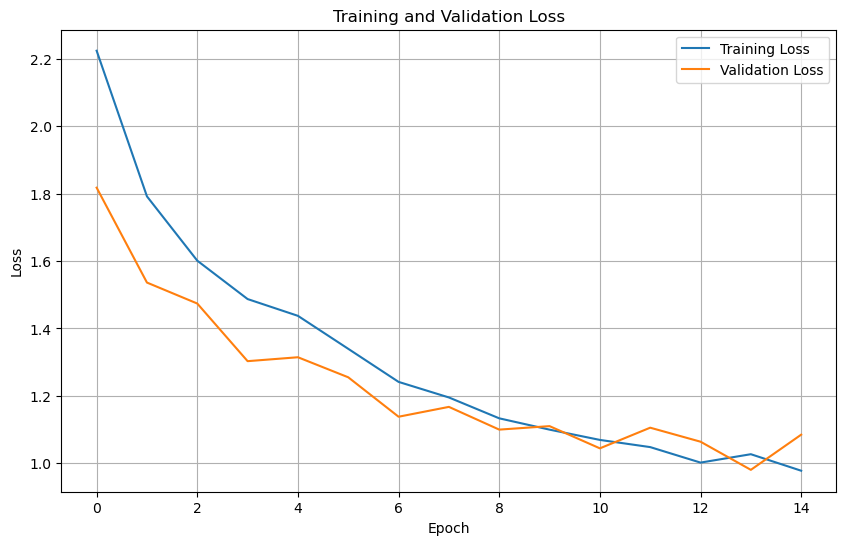

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('train_val_loss.png')
plt.show()


In [ ]:
test_images_dir = Path('./data/test_release')
raw_list = json.load(open('./data/test_image_name_to_ids.json'))
test_image_name_to_ids = {
    entry['file_name']: entry['id'] for entry in raw_list
}

checkpoint_path = 'checkpoints/maskrcnn_epoch_15.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.to(device)
model.eval()
results = []

for image_path in test_images_dir.glob("*.tif"):
    filename = image_path.name
    image_id = test_image_name_to_ids[filename]

    image = Image.open(image_path).convert("RGB")
    image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image_tensor)[0]

    for i in range(len(pred['scores'])):
        if pred['scores'][i] < 0.05:
            continue

        x1, y1, x2, y2 = pred['boxes'][i].tolist()
        bbox = [x1, y1, x2 - x1, y2 - y1]

        binary_mask = pred['masks'][i, 0].cpu().numpy() > 0.5
        rle = encode_mask(binary_mask)

        result = {
            "image_id": image_id,
            "bbox": bbox,
            "score": pred['scores'][i].item(),
            "category_id": pred['labels'][i].item(),
            "segmentation": rle
        }
        results.append(result)

with open('test-results.json', 'w') as f:
    json.dump(results, f, indent=2)

C:\Users\User\AppData\Local\Temp\ipykernel_24440\3705610128.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

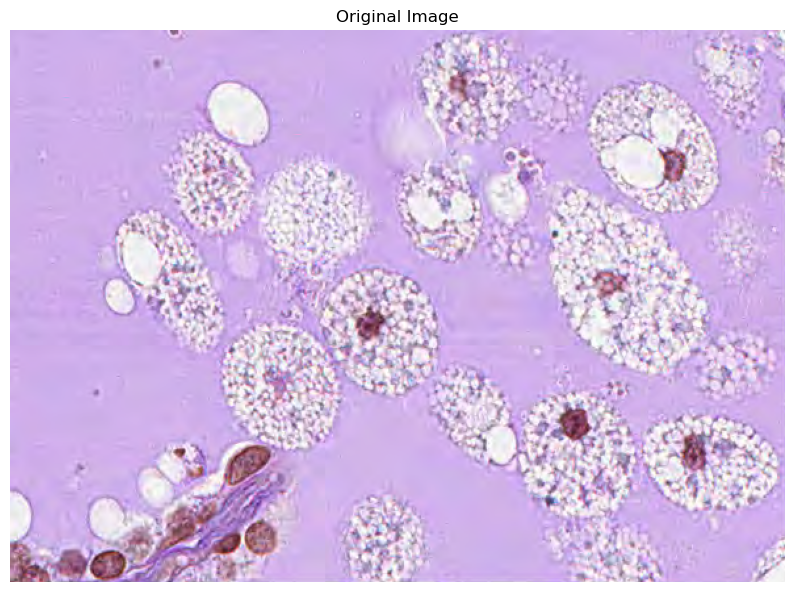

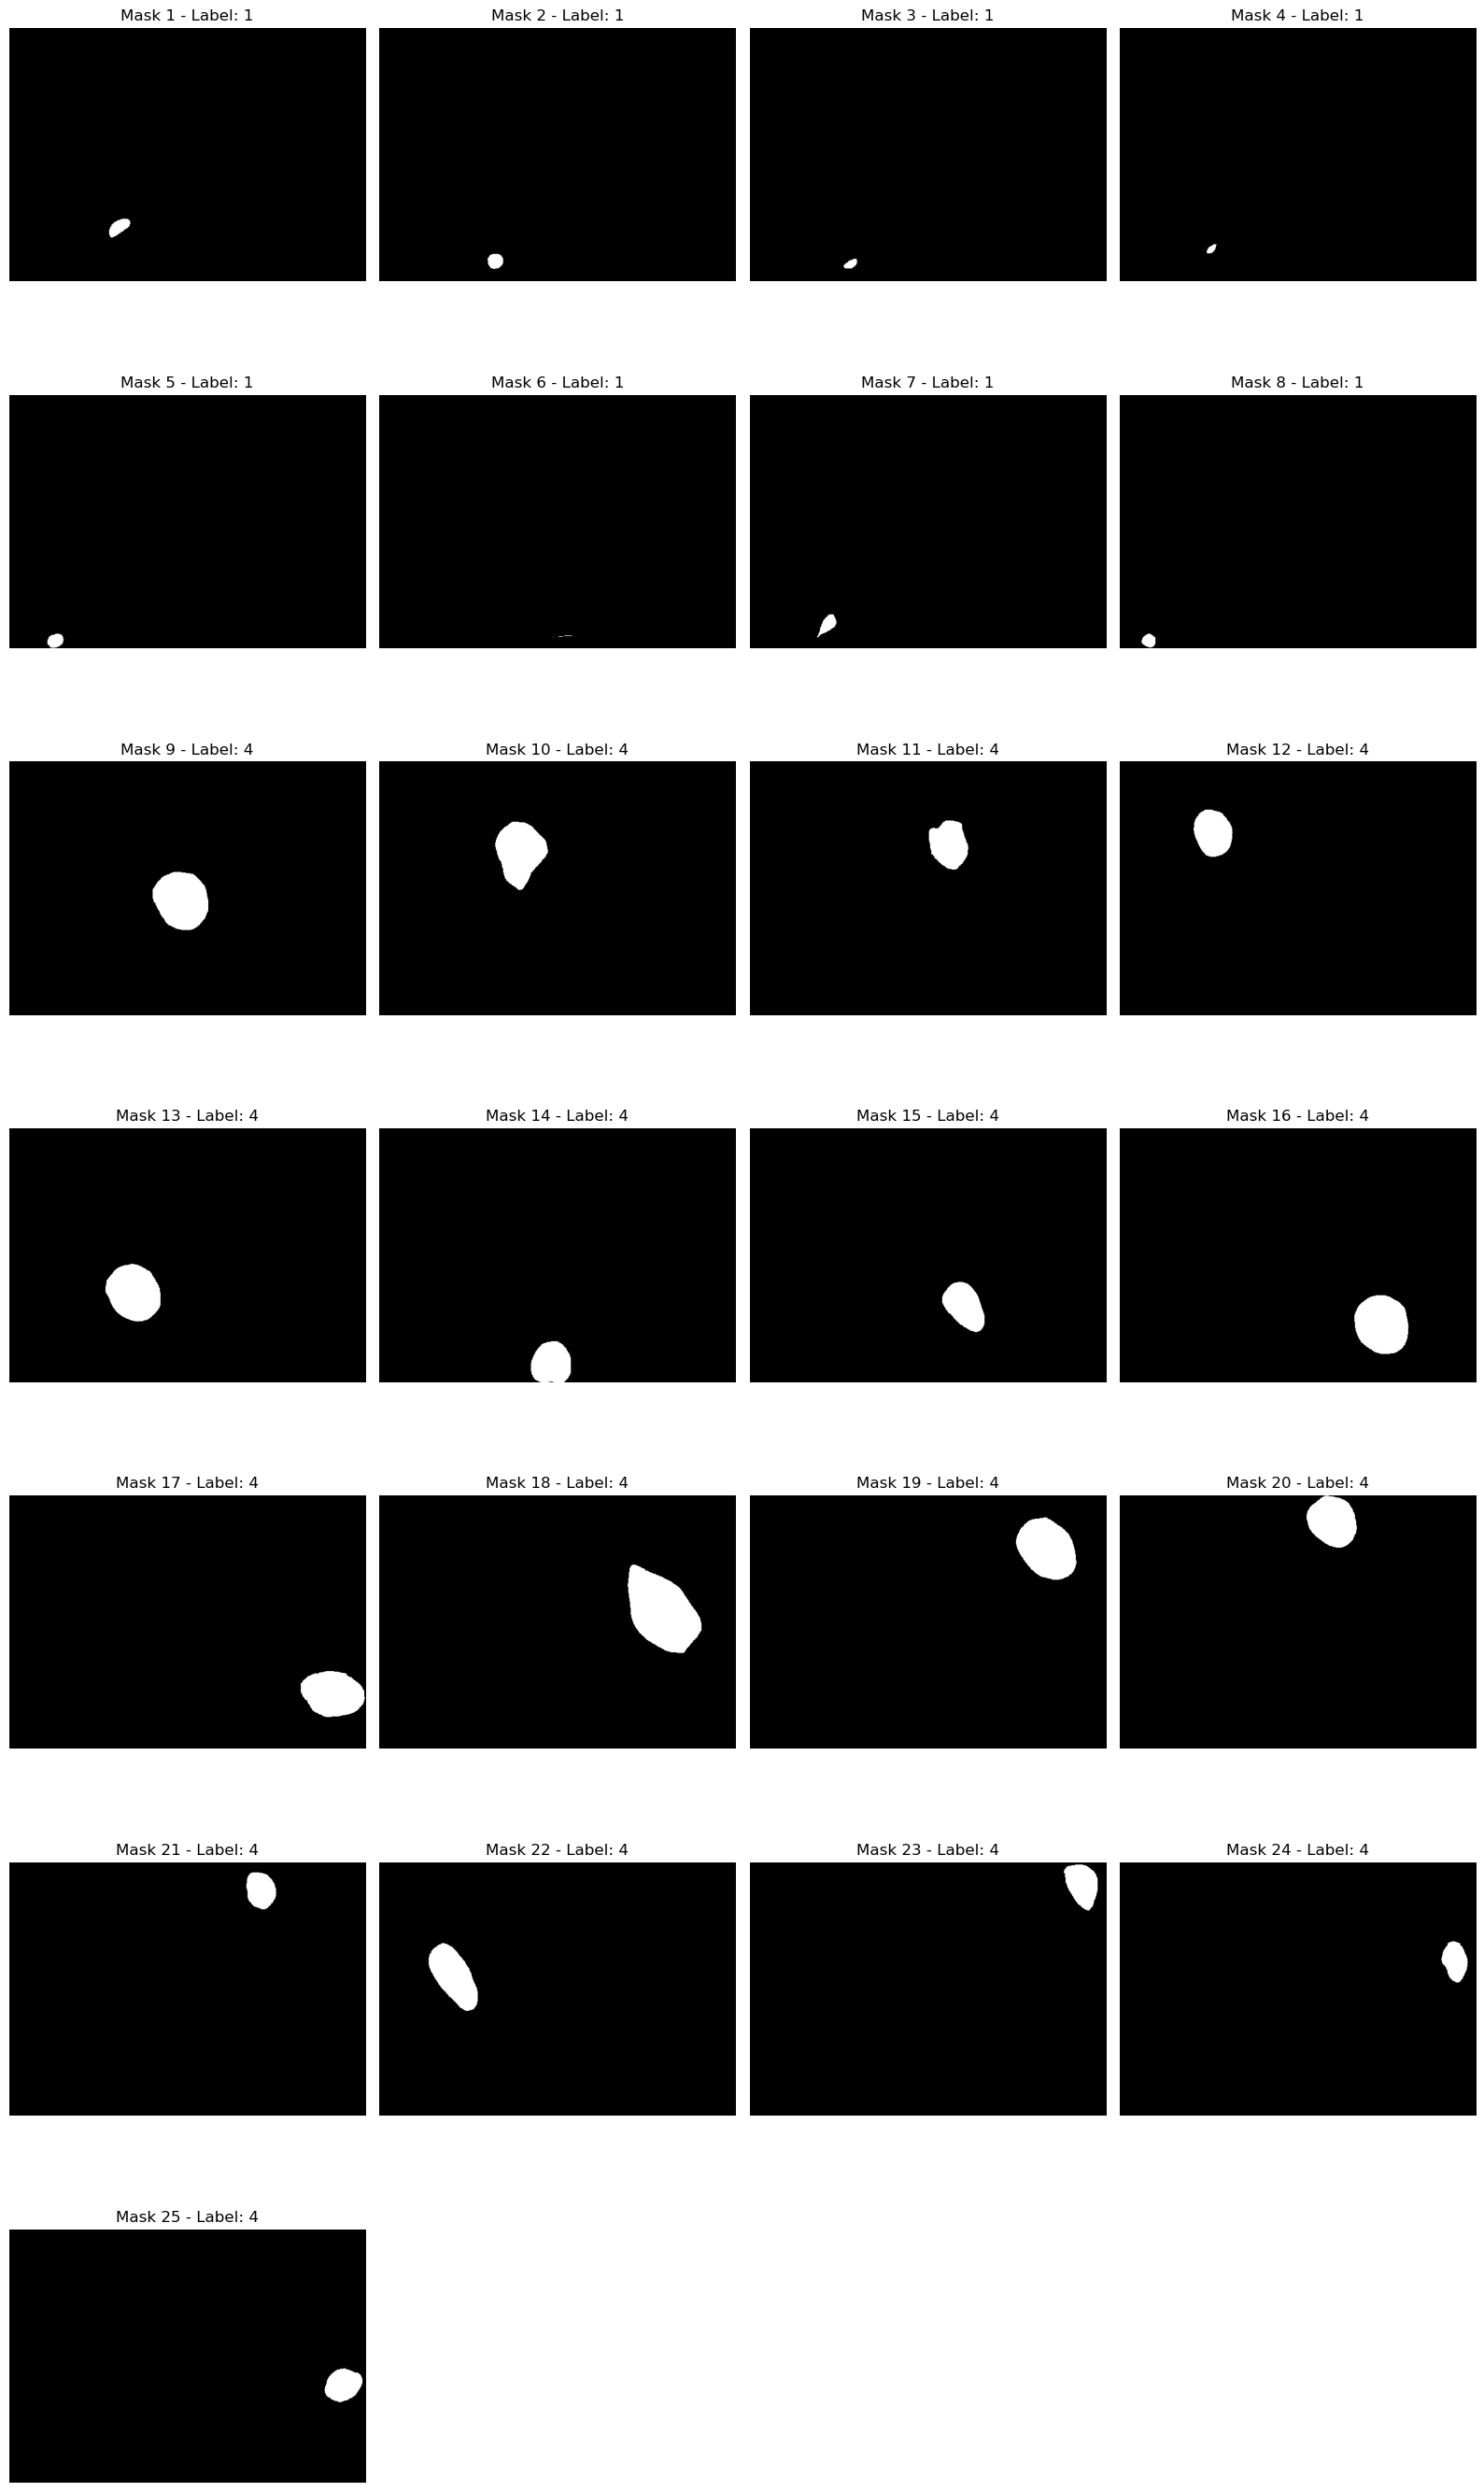

In [ ]:
dataset = CustomDataset(
    image_paths=train_images,
    mask_paths=train_masks,
)
image, target = dataset[3]

plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.savefig('cells-img.png')
plt.show()

num_masks = target['masks'].shape[0]
cols = 4
rows = (num_masks + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))

for i in range(num_masks):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(target['masks'][i], cmap="gray")
    plt.title(f"Mask {i+1} - Label: {target['labels'][i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.savefig('masks_layout.png')
plt.show()
